# Getting Started

This tutorial describes how to use Pandas-TD in Jupyter for exploring data interactively.  To start a Jupyter session, set your API key to the environment variable ``TD_API_KEY`` and run "jupyter notebook":

```sh
$ export TD_API_KEY=1234/abcd...
$ jupyter notebook
```

You can connect to your database by ``create_engine``:

In [1]:
%matplotlib inline

import os
import pandas_td as td

# Set engine type and database, using the default connection
engine = td.create_engine('presto:sample_datasets')

# Alternatively, initialize a connection explicitly
con = td.connect(apikey=os.environ['TD_API_KEY'], endpoint='https://api.treasuredata.com/')
engine = td.create_engine('presto:sample_datasets', con=con)

You can run a query by ``read_td``:

In [2]:
query = '''
select * from nasdaq limit 3
'''
td.read_td(query, engine)

,symbol,open,volume,high,low,close,time
0,LOCM,1.93,60406,2.05,1.8800,1.960,1405353600
1,IMKTA,25.88,29100,26.17,25.6900,26.020,1405353600
2,ISHG,95.83,11830,96.00,95.7927,95.875,1405353600


You can read a table into a DataFrame by ``read_td_table``, optionally with specific time range and limit:

In [3]:
# Read from a table with time range
df = td.read_td_table('nasdaq', engine,
                      time_range=('2000-01-01', '2010-01-01'),
                      limit=10000)

Importing a DataFrame into a table is also supported by ``to_td``:

In [4]:
# Create a DataFrame with random values
df = pd.DataFrame(np.random.rand(3, 3), columns=['x', 'y', 'z'])

# Import it into 'tutorial.tut1'
con = td.connect()
td.to_td(df, 'tutorial.tut1', con, if_exists='replace', index=False)

Note that ``to_td`` currently uses Streaming API for imports.  It takes more than a few seconds until the imported data become visible.

In [5]:
# Check the result after a while
td.read_td_table('tutorial.tut1', engine)

,z,y,x,time
0,0.480272,0.236423,0.872987,1436556748
1,0.004962,0.303897,0.985815,1436556748
2,0.158226,0.748860,0.817781,1436556748


# create_engine

In [6]:
help(td.create_engine)

Help on function create_engine in module pandas_td.td:

create_engine(url, con=None, header=True, show_progress=5.0)
    Create a handler for query engine based on a URL.
    
    The following environment variables are used for default connection:
    
      TD_API_KEY     API key
      TD_API_SERVER  API server (default: api.treasuredata.com)
      HTTP_PROXY     HTTP proxy (optional)
    
    Parameters
    ----------
    url : string
        Engine descriptor in the form "type://apikey@host/database?params..."
        Use shorthand notation "type:database?params..." for the default connection.
    con : Connection, optional
        Handler returned by connect. If not given, default connection is used.
    header : string or boolean, default True
        Prepend comment strings, in the form "-- comment", as a header of queries.
        Set False to disable header.
    show_progress : double or boolean, default 5.0
        Number of seconds to wait before printing progress.
        S

### Examples

In [7]:
# presto
engine = td.create_engine('presto://APIKEY@api.treasuredata.com/sample_datasets')

# hive
engine = td.create_engine('hive://APIKEY@api.treasuredata.com/sample_datasets')

``create_engine`` uses "default" connection if apikey and host are omitted.  In this case, the environment variables "TD_API_KEY" and "TD_API_SERVER" are used to initialize a connection:

In [8]:
# use default connection (TD_API_KEY is used)
engine = td.create_engine('presto:sample_datasets')

If you prefer initializing a connection manually, you can use ``connect``:

In [9]:
# create a connection with detailed parameters (via tdclient.Client)
# See https://github.com/treasure-data/td-client-python/blob/master/tdclient/api.py
con = td.connect(apikey=os.environ['TD_API_KEY'],
                 endpoint='https://api.treasuredata.com/',
                 retry_post_requests=True)
engine = td.create_engine('presto:sample_datasets', con=con)

# read_td_query

In [10]:
help(td.read_td_query)

Help on function read_td_query in module pandas_td.td:

read_td_query(query, engine, index_col=None, parse_dates=None, distributed_join=False, params=None)
    Read Treasure Data query into a DataFrame.
    
    Returns a DataFrame corresponding to the result set of the query string.
    Optionally provide an index_col parameter to use one of the columns as
    the index, otherwise default integer index will be used.
    
    Parameters
    ----------
    query : string
        Query string to be executed.
    engine : QueryEngine
        Handler returned by create_engine.
    index_col : string, optional
        Column name to use as index for the returned DataFrame object.
    parse_dates : list or dict, optional
        - List of column names to parse as dates
        - Dict of {column_name: format string} where format string is strftime
          compatible in case of parsing string times or is one of (D, s, ns, ms, us)
          in case of parsing integer timestamps
    distribute

### Examples

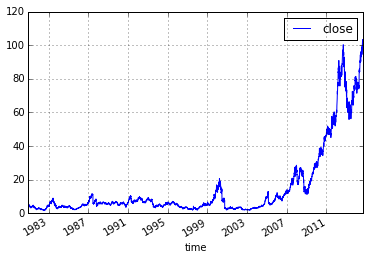

In [11]:
query = '''
select time, close from nasdaq where symbol='AAPL'
'''

# Run a query, converting "time" to a time series index
df = td.read_td_query(query, engine, index_col='time', parse_dates={'time': 's'})
df.plot()

# read_td_table

In [12]:
help(td.read_td_table)

Help on function read_td_table in module pandas_td.td:

read_td_table(table_name, engine, index_col=None, parse_dates=None, columns=None, time_range=None, sample=None, limit=10000)
    Read Treasure Data table into a DataFrame.
    
    The number of returned rows is limited by "limit" (default 10,000).
    Setting limit=None means all rows. Be careful when you set limit=None
    because your table might be very large and the result does not fit into memory.
    
    Parameters
    ----------
    table_name : string
        Name of Treasure Data table in database.
    engine : QueryEngine
        Handler returned by create_engine.
    index_col : string, optional
        Column name to use as index for the returned DataFrame object.
    parse_dates : list or dict, optional
        - List of column names to parse as dates
        - Dict of {column_name: format string} where format string is strftime
          compatible in case of parsing string times or is one of (D, s, ns, ms, us)
   

### Examples

In [13]:
# Read all records (up to 10,000 rows by default)
df = td.read_td_table("www_access", engine)
df.head(3)

,user,host,path,referer,code,agent,size,method,time
0,None,192.225.229.196,/category/software,-,200,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; r...,117,GET,1412382292
1,None,120.168.215.131,/category/software,-,200,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,53,GET,1412382284
2,None,180.198.173.136,/category/electronics,/category/computers,200,Mozilla/5.0 (Windows NT 6.0) AppleWebKit/535.1...,106,GET,1412382275


In [14]:
# From 1990 to 2010, 1-percent sample, no limit
df = td.read_td_table("nasdaq",
                      engine,
                      index_col='time',
                      parse_dates={'time': 's'},
                      columns=['time', 'symbol', 'close'],
                      time_range=('1990', '2010'),
                      sample=0.01,
                      limit=None)
len(df)

55268

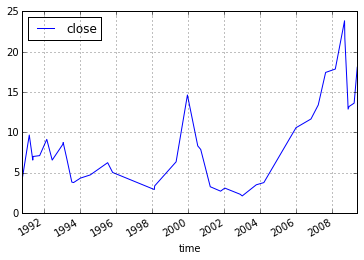

In [15]:
df[df.symbol=='AAPL'].plot()

# to_td

In [16]:
help(td.to_td)

Help on function to_td in module pandas_td.td:

to_td(frame, name, con, if_exists='fail', time_col=None, time_index=None, index=True, index_label=None, chunksize=10000, date_format=None)
    Write a DataFrame to a Treasure Data table.
    
    This method converts the dataframe into a series of key-value pairs
    and send them using the Treasure Data streaming API. The data is divided
    into chunks of rows (default 10,000) and uploaded separately. If upload
    failed, the client retries the process for a certain amount of time
    (max_cumul_retry_delay; default 600 secs). This method may fail and
    raise an exception when retries did not success, in which case the data
    may be partially inserted. Use the bulk import utility if you cannot
    accept partial inserts.
    
    Parameters
    ----------
    frame : DataFrame
        DataFrame to be written.
    name : string
        Name of table to be written, in the form 'database.table'.
    con : Connection
        Connection

### Examples

In [17]:
# Create a DataFrame with random values
df = pd.DataFrame(np.random.rand(3, 3), columns=['x', 'y', 'z'])

``to_td`` fails if table already exists:

In [18]:
td.to_td(df, 'tutorial.tut1', con)

RuntimeError: table "tutorial.tut1" already exists

In [19]:
# Set "if_exists" to 'replace' or 'append'
td.to_td(df, 'tutorial.tut1', con, if_exists='replace')

Use ``index=False`` if you don't need to insert DataFrame index:

In [20]:
td.to_td(df, 'tutorial.tut1', con, if_exists='replace', index=False)

``to_td`` inserts the current time as "time" column.  You can pass "time" column explicitly by ``time_col``:

In [21]:
import datetime

df = pd.DataFrame(np.random.rand(3, 3), columns=['x', 'y', 'z'])

# Set "time" column explicitly
df['time'] = datetime.datetime.now()

# Use "time" as the time column in Treasure Data
td.to_td(df, 'tutorial.tut1', con, if_exists='replace', index=False, time_col='time')

If you are using a time series index, set ``time_index=0``:

In [22]:
df = pd.DataFrame(np.random.rand(3, 3), columns=['x', 'y', 'z'])

# Set time series index
df.index = pd.date_range('2001-01-01', periods=3)

# Use index as the time column in Treasure Data
td.to_td(df, 'tutorial.tut1', con, if_exists='replace', index=False, time_index=0)